In [6]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, classification_report
import pickle

In [7]:
from skimage.feature import hog

hog_params = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys'
}

In [8]:
data_dir = './CK+48/' 
classes = os.listdir(data_dir)
num_classes = len(classes)
X = []
y = []
input_size = (64, 64)

for label_index, class_name in enumerate(classes):
    class_path = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        
        if image is not None:
         # Preprocessing
            resized_image = cv2.resize(image, input_size)
            gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
            blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
            
            
            feature = hog(blurred_image, **hog_params)
            # feature = extract_lbp_features(blurred_image)

            X.append(feature)
            y.append(label_index)

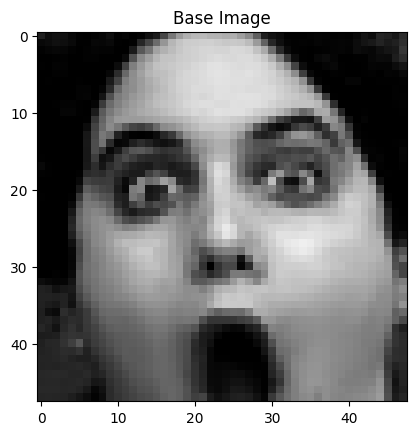

In [9]:
dummy_img = './CK+48/surprise/S124_001_00000014.png'
image = cv2.imread(dummy_img)
plt.imshow(image)
plt.title('Base Image')
plt.show()

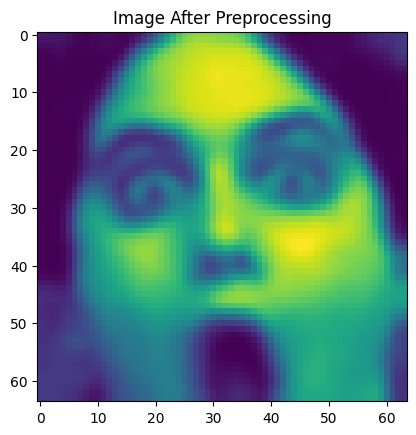

In [10]:
dummy_img = './CK+48/surprise/S124_001_00000014.png'
image = cv2.imread(dummy_img)
resized_image = cv2.resize(image, input_size)
gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
plt.imshow(blurred_image)
plt.title('Image After Preprocessing')
plt.show()

In [11]:
x = np.array(X)
y = np.array(y)

In [12]:
# x = x.astype('float32')/255
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, stratify=y, random_state=42)

In [14]:
# print("Distribusi kelas sebelum oversampling:")
# print(pd.Series(y_train).value_counts())

In [15]:
# from imblearn.over_sampling import SMOTE
# random = SMOTE(random_state=42)
# X_train_oversampled, y_train_oversampled = random.fit_resample(X_train, y_train)

In [16]:
# print("\nDistribusi kelas setelah oversampling:")
# print(pd.Series(y_train_oversampled).value_counts())  # y_train_oversampled adalah label target setelah oversampling

# # Visualisasi distribusi kelas
# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# pd.Series(y_train).value_counts().plot(kind='bar', ax=ax[0], title='Sebelum Oversampling')
# pd.Series(y_train_oversampled).value_counts().plot(kind='bar', ax=ax[1], title='Setelah Oversampling')
# plt.show()

In [17]:
model = RandomForestClassifier(n_estimators= 100, random_state=42)
model.fit(X_train, y_train)

# svm = SVC(random_state=42)

RandomForestClassifier(random_state=42)

In [18]:
y_pred = model.predict(X_test)

In [19]:
# cm = confusion_matrix(y_test,y_pred)
# plt.imshow(cm)
# plt.colorbar()
# plt.xlabel('gatau')
# plt.ylabel('pp')
# plt.show()

In [20]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100}")

Accuracy: 96.95431472081218


In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        27
           1       1.00      1.00      1.00        11
           2       1.00      0.89      0.94        35
           3       1.00      0.93      0.97        15
           4       0.91      1.00      0.95        42
           5       1.00      1.00      1.00        17
           6       0.98      1.00      0.99        50

    accuracy                           0.97       197
   macro avg       0.98      0.97      0.97       197
weighted avg       0.97      0.97      0.97       197



In [22]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, x, y, cv=5, scoring='accuracy')
print(f"Mean Accuracy (CV): {scores.mean():.2f}")

Mean Accuracy (CV): 0.78


In [23]:
print(classes)

['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']


In [24]:
def preprocess_and_predict(image_path, model, scaler, hog_params):
    # Baca gambar
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Gambar di {image_path} tidak ditemukan atau tidak valid.")
    
    # Preprocessing
    input_size = (64, 64)
    resized_image = cv2.resize(image, input_size)
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    
    # Ekstraksi fitur menggunakan HOG
    feature = hog(blurred_image, **hog_params)
    feature = np.array([feature])  # Ubah ke bentuk 2D (1, n_features)
    
    # Standarisasi
    feature_scaled = scaler.transform(feature)
    
    # Prediksi dengan model
    prediction = model.predict(feature_scaled)
    
    return prediction[0]  # Mengembalikan label prediksi

# Contoh penggunaan
image_path = './im2.png'  # Ganti dengan path gambar baru
predicted_label = preprocess_and_predict(image_path, model, scaler, hog_params)

print(f"Prediksi Kelas: {classes[predicted_label]}")

Prediksi Kelas: happy


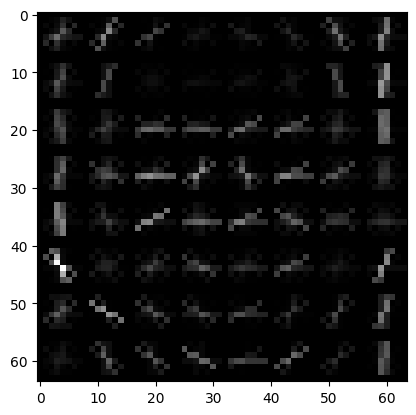

In [25]:
image = cv2.imread(image_path)
image = cv2.resize(image, (64,64))
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.GaussianBlur(image, (5, 5), 0)
hog_features, hog_image = hog(
    image,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    block_norm='L2-Hys',
    visualize=True,  
    transform_sqrt=True
)

# Menampilkan visualisasi HOG
plt.imshow(hog_image, cmap=plt.cm.gray)


In [26]:
model_data = {
    'model_hog': model,
    'scaler_hog' : scaler,
    'class_hog' : classes,
    'input_size_hog': input_size
}

In [27]:
with open('HoG_model.pkl', 'wb') as file:
    pickle.dump(model_data, file)